In [125]:
# Imports


import requests
import zipfile
import io
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pytz
import numpy as np
import math
import warnings
import seaborn as sns
import os
import shutil
import datetime

# Suppress specific warnings (in this case, FutureWarnings)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sktime.clustering.k_medoids import TimeSeriesKMedoids
from scipy.fftpack import fft, fftfreq
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score, davies_bouldin_score
from tslearn.clustering import KShape
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import DBSCAN
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

from tqdm.notebook import tqdm


In [126]:
def calculate_mape(y_true, y_pred):
  return mean_absolute_percentage_error(y_true, y_pred) * 100

In [127]:
NUM_CLUSTERS = 4

all_data_df = pd.DataFrame()
clustered_customers = list()

for i in range(1, NUM_CLUSTERS + 1):
    df = pd.concat([
        pd.read_parquet(f'../dataset/cluster_{i}/training.parquet'),
        pd.read_parquet(f'../dataset/cluster_{i}/validation.parquet'),
        pd.read_parquet(f'../dataset/cluster_{i}/test.parquet'),
    ], axis=1).T.sort_index()
    df.index = pd.to_datetime(df.index)
    df.index.name = 'date'
    clustered_customers.append(list(df.columns))
    all_data_df  = pd.concat([all_data_df, df], axis=1)

In [128]:
customers = ['MT_091', 'MT_100', 'MT_101', 'MT_104', 'MT_137', 'MT_139', 'MT_145', 'MT_147', 'MT_166', 'MT_168', 'MT_175', 'MT_180', 'MT_182', 'MT_190', 'MT_193', 'MT_194', 'MT_195', 'MT_200', 'MT_204', 'MT_210', 'MT_212', 'MT_213', 'MT_215', 'MT_216', 'MT_218', 'MT_220', 'MT_222', 'MT_225', 'MT_227', 'MT_232', 'MT_233', 'MT_234', 'MT_237', 'MT_238', 'MT_239', 'MT_242', 'MT_243', 'MT_247', 'MT_248', 'MT_250', 'MT_251', 'MT_252', 'MT_253', 'MT_254', 'MT_256', 'MT_257', 'MT_258', 'MT_259', 'MT_261', 'MT_264', 'MT_266', 'MT_269', 'MT_271', 'MT_273', 'MT_274', 'MT_277', 'MT_278', 'MT_280', 'MT_282', 'MT_283', 'MT_285', 'MT_287', 'MT_294', 'MT_296', 'MT_298', 'MT_300', 'MT_301', 'MT_303', 'MT_304', 'MT_306', 'MT_307', 'MT_309', 'MT_310', 'MT_311', 'MT_313', 'MT_314', 'MT_315', 'MT_317', 'MT_318', 'MT_319', 'MT_320', 'MT_321', 'MT_323', 'MT_324', 'MT_326', 'MT_327', 'MT_328', 'MT_329', 'MT_341', 'MT_345', 'MT_350', 'MT_352', 'MT_353', 'MT_356', 'MT_357', 'MT_360', 'MT_363', 'MT_364', 'MT_365', 'MT_369', 'MT_098', 'MT_099', 'MT_103', 'MT_105', 'MT_126', 'MT_154', 'MT_172', 'MT_189', 'MT_191', 'MT_192', 'MT_197', 'MT_198', 'MT_199', 'MT_201', 'MT_202', 'MT_203', 'MT_205', 'MT_206', 'MT_207', 'MT_209', 'MT_211', 'MT_214', 'MT_217', 'MT_221', 'MT_229', 'MT_230', 'MT_231', 'MT_236', 'MT_240', 'MT_244', 'MT_245', 'MT_246', 'MT_263', 'MT_275', 'MT_286', 'MT_293', 'MT_297', 'MT_312', 'MT_325', 'MT_330', 'MT_335', 'MT_338', 'MT_339', 'MT_340', 'MT_343', 'MT_344', 'MT_346', 'MT_349', 'MT_351', 'MT_354', 'MT_355', 'MT_358', 'MT_361', 'MT_068', 'MT_150', 'MT_171', 'MT_260', 'MT_262', 'MT_265', 'MT_268', 'MT_270', 'MT_281', 'MT_284', 'MT_292', 'MT_295', 'MT_299', 'MT_331', 'MT_342', 'MT_148', 'MT_149', 'MT_161', 'MT_196', 'MT_228', 'MT_267', 'MT_276', 'MT_359', 'MT_208', 'MT_279', 'MT_362', 'MT_119', 'MT_007', 'MT_102', 'MT_272', 'MT_174', 'MT_241', 'MT_226', 'MT_141', 'MT_138', 'MT_316', 'MT_142', 'MT_143', 'MT_125', 'MT_118', 'MT_086', 'MT_057', 'MT_002', 'MT_051', 'MT_176', 'MT_169', 'MT_073', 'MT_079', 'MT_082', 'MT_004', 'MT_008', 'MT_017', 'MT_020', 'MT_027', 'MT_028', 'MT_031', 'MT_034', 'MT_037', 'MT_042', 'MT_043', 'MT_044', 'MT_048', 'MT_050', 'MT_053', 'MT_054', 'MT_056', 'MT_060', 'MT_062', 'MT_065', 'MT_069', 'MT_071', 'MT_072', 'MT_074', 'MT_075', 'MT_076', 'MT_080', 'MT_081', 'MT_083', 'MT_085', 'MT_088', 'MT_089', 'MT_334', 'MT_011', 'MT_016', 'MT_019', 'MT_021', 'MT_026', 'MT_035', 'MT_046', 'MT_049', 'MT_058', 'MT_061', 'MT_063', 'MT_070', 'MT_018', 'MT_059', 'MT_087', 'MT_005', 'MT_006', 'MT_025', 'MT_052', 'MT_067', 'MT_333', 'MT_336', 'MT_235', 'MT_291', 'MT_014', 'MT_077', 'MT_095', 'MT_096', 'MT_164']


In [129]:
explanatory_variables_df = pd.read_parquet('../dataset/combined_explanatory_variables/explanatory_variables.parquet')
explanatory_variables_df.index = pd.to_datetime(explanatory_variables_df.index)
explanatory_variables_df = explanatory_variables_df.sort_index().asfreq('D')

In [130]:
combined_df = pd.concat([all_data_df, explanatory_variables_df], axis=1)
combined_df = combined_df.reset_index().rename(columns={'date': 'ds'})
combined_df = combined_df.dropna()

In [131]:
combined_df

,ds,MT_091,MT_100,MT_101,MT_104,MT_137,MT_139,MT_145,MT_147,MT_166,...,MT_095,MT_096,MT_164,heating_degree_days,cooling_degree_days,precip,precipprob,is_holiday,sunlight_length_hours,is_weekend
1,2012-01-02,3141.260841,1076.731025,16256.968641,15931.188119,1624.679761,10049.958018,1999.556999,65745.121951,26916.456044,...,836.039811,407.681159,4047.715549,6.659918,0.0,0.111,1.0,0,10.0,0
2,2012-01-03,3424.616411,1134.653795,16126.742160,16241.584158,1649.017933,10182.619647,2009.155346,65919.512195,27458.681319,...,863.803038,412.318841,4247.052321,7.977833,0.0,0.000,0.0,0,10.0,0
3,2012-01-04,3465.810540,1145.639148,16458.623693,16033.663366,1572.587532,10345.298069,2012.551683,66129.268293,27612.554945,...,830.539550,427.391304,4322.586588,6.335269,0.0,0.000,0.0,0,10.0,0
4,2012-01-05,3578.052035,1145.472703,16255.226481,15864.356436,1538.215201,10358.522250,2029.385706,67131.707317,25971.510989,...,809.717129,416.231884,4375.460575,7.437771,0.0,0.000,0.0,0,10.0,0
5,2012-01-06,3697.965310,1138.149134,16904.616725,16317.326733,1601.622545,10200.881612,2000.886001,66734.146341,27706.236264,...,815.348350,420.579710,4290.899042,8.166583,0.0,0.000,0.0,0,10.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2014-12-27,2835.223482,773.302264,14097.560976,11474.752475,1540.777114,5661.209068,1528.942705,56764.634146,27662.115385,...,313.253012,228.985507,2261.053795,9.032632,0.0,0.000,0.0,0,9.0,1
1092,2014-12-28,2871.581054,771.637816,14272.648084,11610.396040,1412.467976,5866.078925,1580.330774,56960.975610,27535.796703,...,79.622839,186.521739,1951.363301,7.697900,0.0,0.000,0.0,0,9.0,1
1093,2014-12-29,2740.827218,810.918775,14086.672474,11586.633663,1705.166524,6769.101595,1591.848789,56775.609756,26334.258242,...,778.548979,348.260870,3478.813559,10.921202,0.0,0.000,0.0,0,9.0,0
1094,2014-12-30,2884.589726,825.066578,13780.487805,11279.702970,1711.998292,6867.338371,1603.662138,56121.951220,26405.824176,...,751.047669,361.014493,3454.863670,11.066679,0.0,0.000,0.0,0,9.0,0


In [132]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

cutoff_date = pd.to_datetime('2014-01-01')

mape_values = dict()
predictions = dict()

for customer in customers:
    customer_df = combined_df.rename(columns={customer: 'y'})
    train_df = customer_df[customer_df.ds < cutoff_date]
    test_df = customer_df[customer_df.ds >= cutoff_date]
    
    # Exponential Smoothing model - Holt-Winters (additive or multiplicative depending on your data)
    model = ExponentialSmoothing(
        train_df['y'],
        trend='add',      # or 'mul' for multiplicative trend
        seasonal='add',   # or 'mul' for multiplicative seasonality, or None
        seasonal_periods=365# set this to your seasonality, e.g., 12 for monthly seasonality
    )

    fitted_model = model.fit()
    
    # Forecasting for the length of the test set
    forecast = fitted_model.forecast(steps=len(test_df))
    
    mape = calculate_mape(test_df['y'], forecast)
    mape_values[customer] = mape
    
    forecast_df = test_df.copy()
    forecast_df['yhat'] = forecast.values
    predictions[customer] = forecast_df

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an inte

Cluster 1 Average MAPE: 39.5298
Minimum MAPE for Cluster 1: 5.2308819939347035
Maximum MAPE for Cluster 1: 532.9152689080262


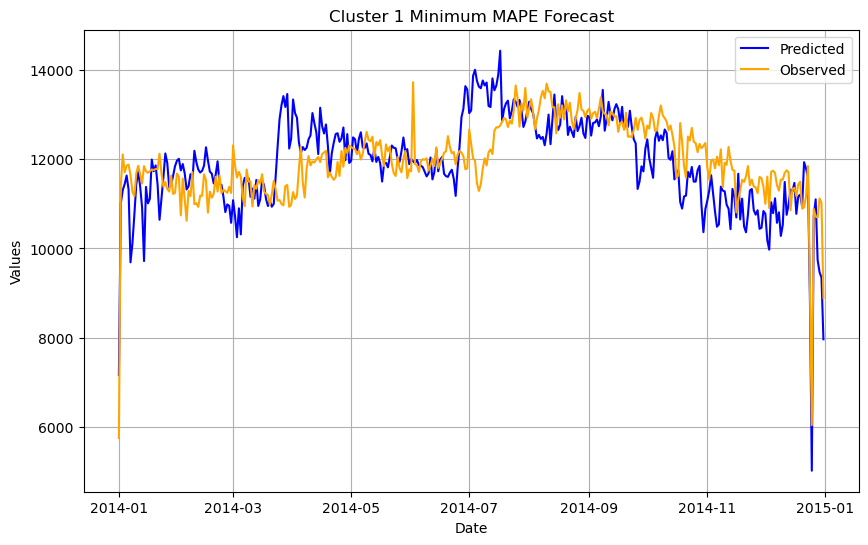

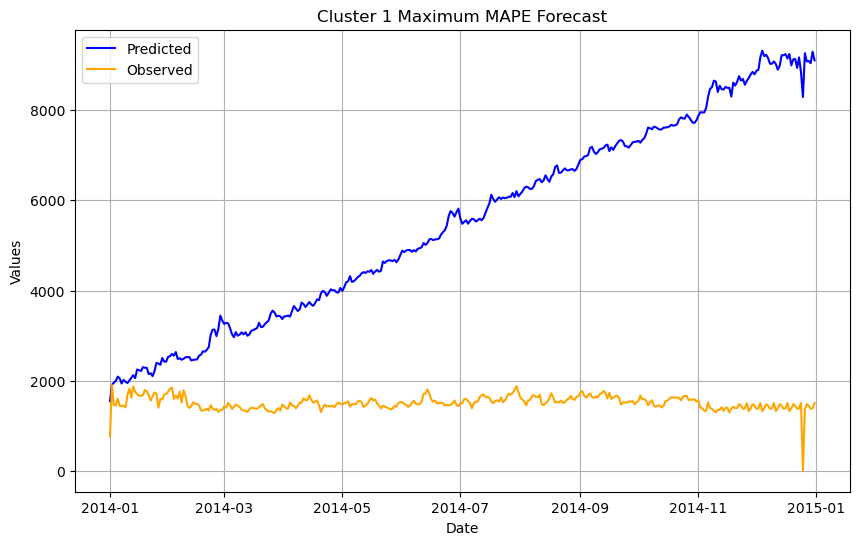

Cluster 2 Average MAPE: 79.0859
Minimum MAPE for Cluster 2: 6.625937235212946
Maximum MAPE for Cluster 2: 296.13404721532606


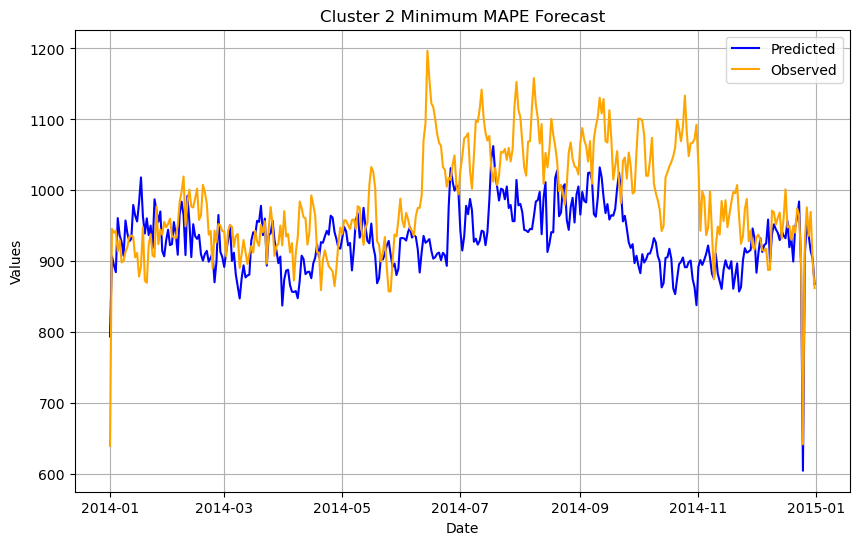

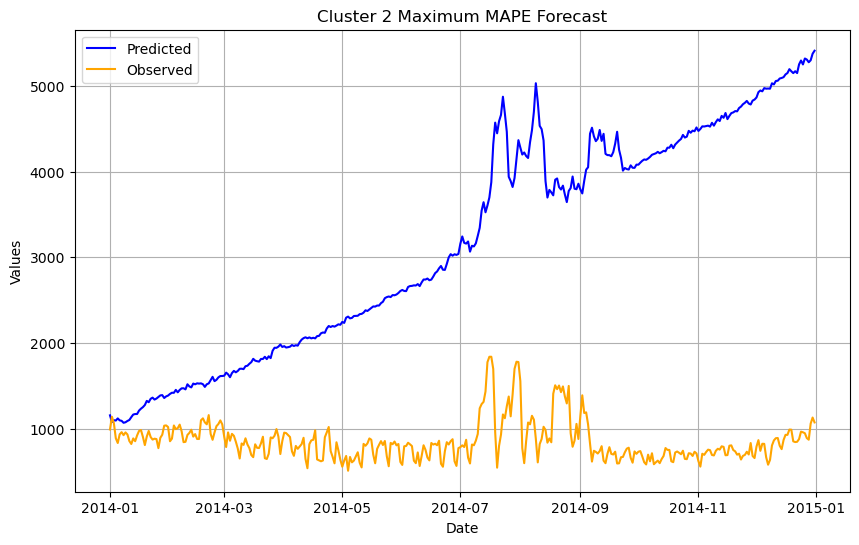

Cluster 3 Average MAPE: 72.5640
Minimum MAPE for Cluster 3: 6.924187322246565
Maximum MAPE for Cluster 3: 618.5397063333281


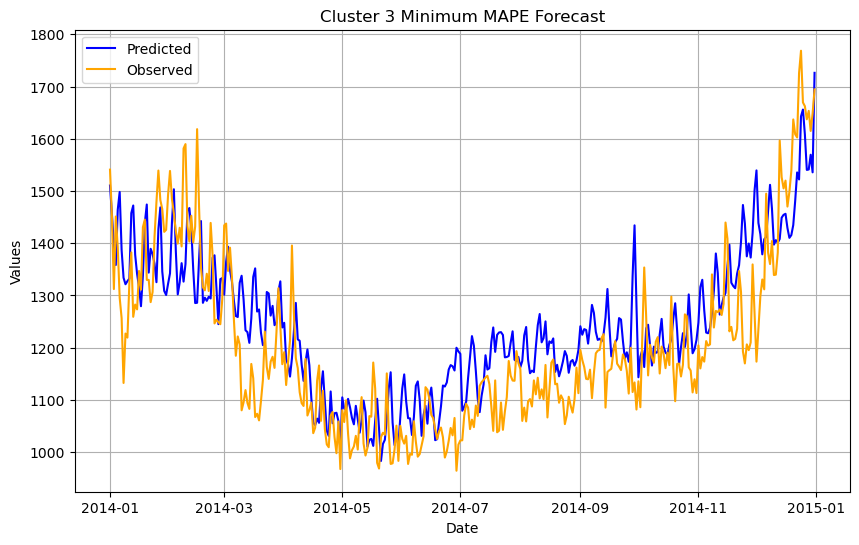

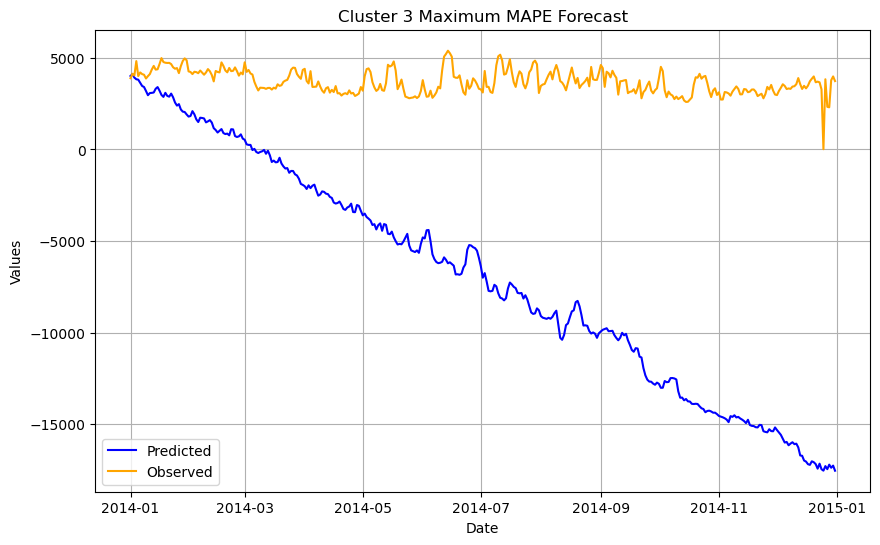

Cluster 4 Average MAPE: 55.6482
Minimum MAPE for Cluster 4: 20.225991589112684
Maximum MAPE for Cluster 4: 94.97437483053875


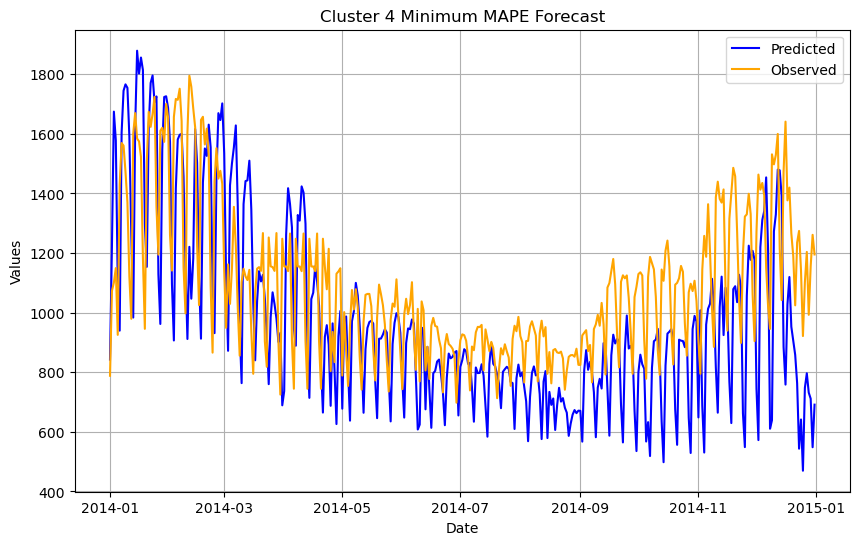

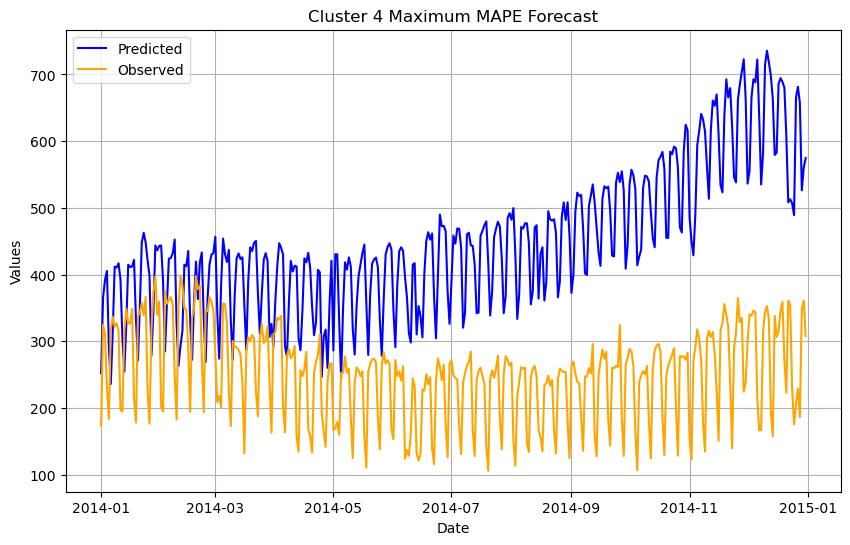

In [141]:
average_mapes = []  # store average MAPE per cluster

for i in range(len(clustered_customers)):
    min_mape = clustered_customers[i][0]
    max_mape = clustered_customers[i][0]
    
    mape_sum = 0.0
    for customer in clustered_customers[i]:
        if mape_values[customer] < mape_values[min_mape]:
            min_mape = customer
        if mape_values[customer] > mape_values[max_mape]:
            max_mape = customer
        mape_sum += mape_values[customer]

    # Compute average for the cluster
    cluster_size = len(clustered_customers[i])
    avg_mape = mape_sum / cluster_size
    average_mapes.append(avg_mape)

    print(f'Cluster {i+1} Average MAPE: {avg_mape:.4f}')
    print(f'Minimum MAPE for Cluster {i+1}: {mape_values[min_mape]}')
    print(f'Maximum MAPE for Cluster {i+1}: {mape_values[max_mape]}')

    # Plotting Minimum MAPE Forecast
    plt.figure(figsize=(10, 6))
    plt.plot(predictions[min_mape]['ds'], predictions[min_mape]['yhat'], label='Predicted', color='blue')
    plt.plot(predictions[min_mape]['ds'], combined_df[customer_df.ds >= cutoff_date][min_mape], label='Observed', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title(f'Cluster {i+1} Minimum MAPE Forecast')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'my_plot{i+1}.png')
    plt.show()

    # Plotting Maximum MAPE Forecast
    plt.figure(figsize=(10, 6))
    plt.plot(predictions[max_mape]['ds'], predictions[max_mape]['yhat'], label='Predicted', color='blue')
    plt.plot(predictions[max_mape]['ds'], combined_df[customer_df.ds >= cutoff_date][max_mape], label='Observed', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title(f'Cluster {i+1} Maximum MAPE Forecast')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'my_plot_max{i+1}.png')
    plt.show()

In [147]:
# Step 1: Collect all MAPEs across all clusters
all_mapes = [mape for customer, mape in mape_values.items()]

# Step 2: Sort them in ascending order
sorted_all_mapes = sorted(all_mapes)

# Step 3: Remove top 5%
cutoff_index = int(len(sorted_all_mapes) * 0.95)  # Keep 95%
trimmed_mapes = sorted_all_mapes[:cutoff_index]

# Step 4: Compute average on the remaining 95%
overall_trimmed_avg_mape = sum(trimmed_mapes) / len(trimmed_mapes)

print(f'Overall Trimmed Average MAPE (w/o top 5%): {overall_trimmed_avg_mape:.4f}')


Overall Trimmed Average MAPE (w/o top 5%): 36.5669


Minimum MAPE for Cluster 1: 5.2308819939347035


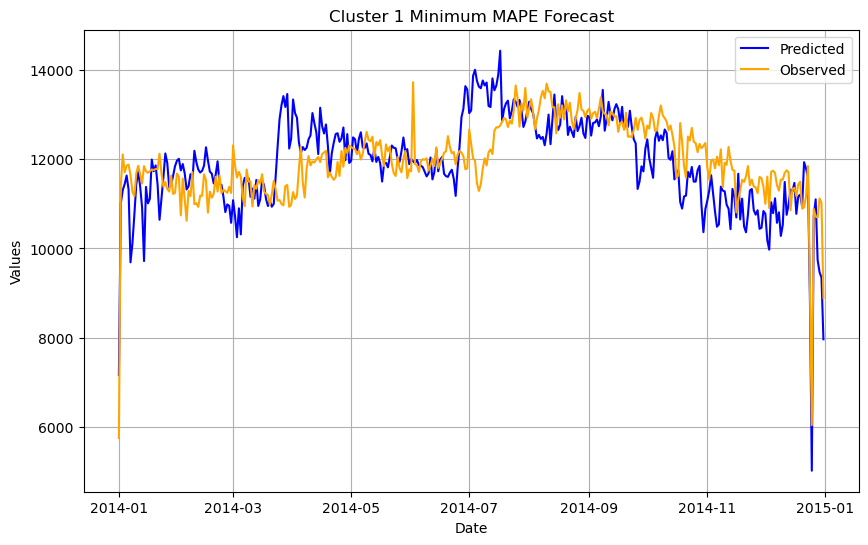

Maximum MAPE for Cluster 1: 532.9152689080262


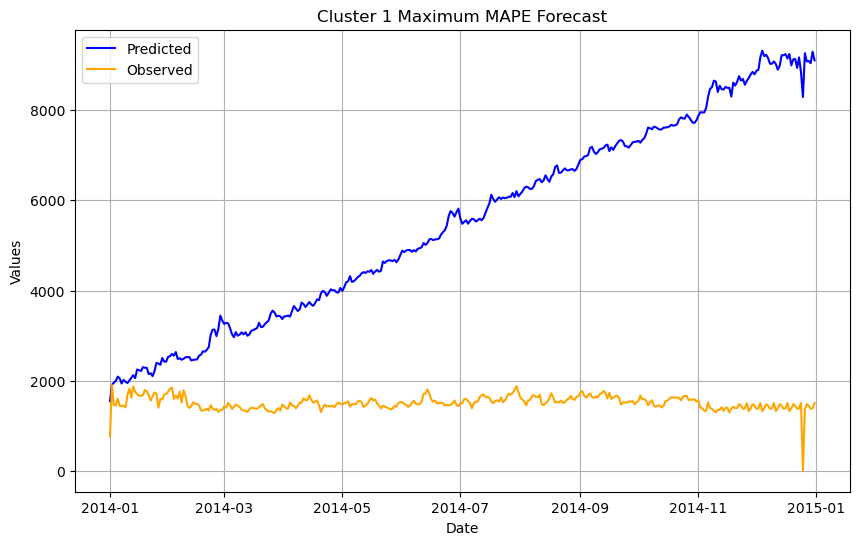

Minimum MAPE for Cluster 2: 6.625937235212946


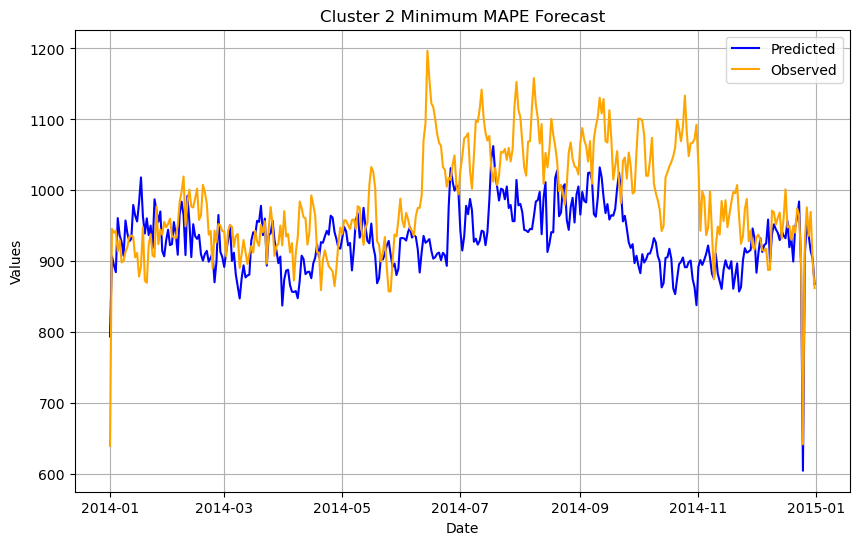

Maximum MAPE for Cluster 2: 296.13404721532606


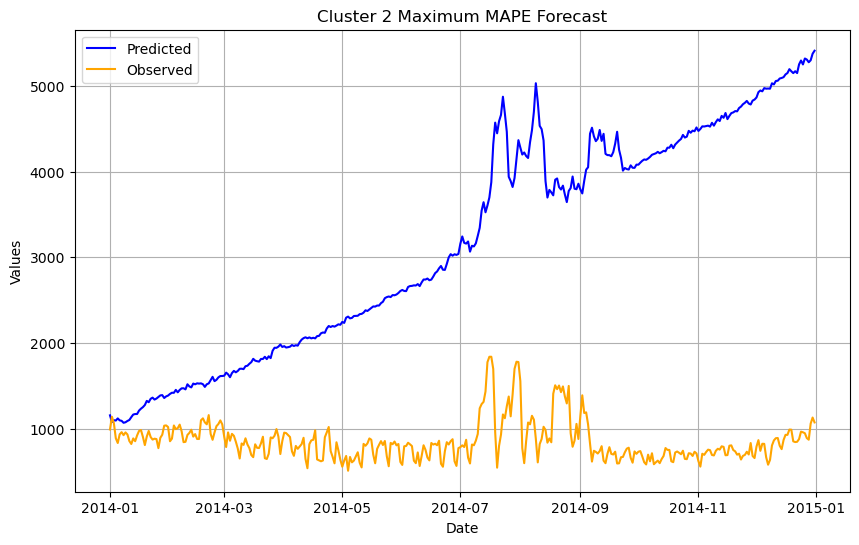

Minimum MAPE for Cluster 3: 6.924187322246565


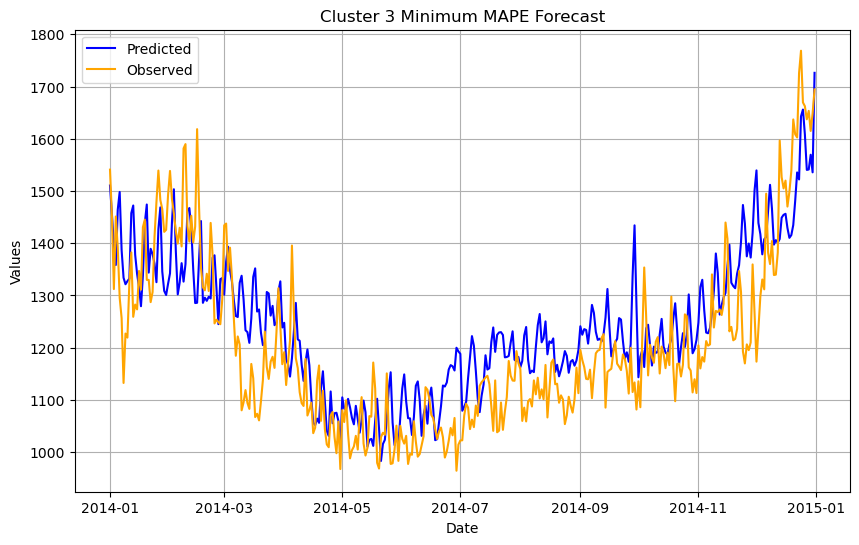

Maximum MAPE for Cluster 3: 618.5397063333281


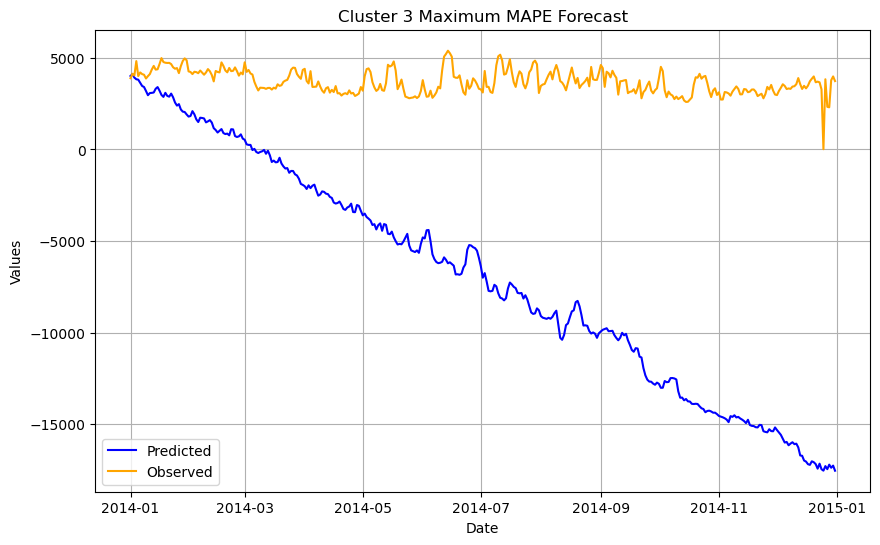

Minimum MAPE for Cluster 4: 20.225991589112684


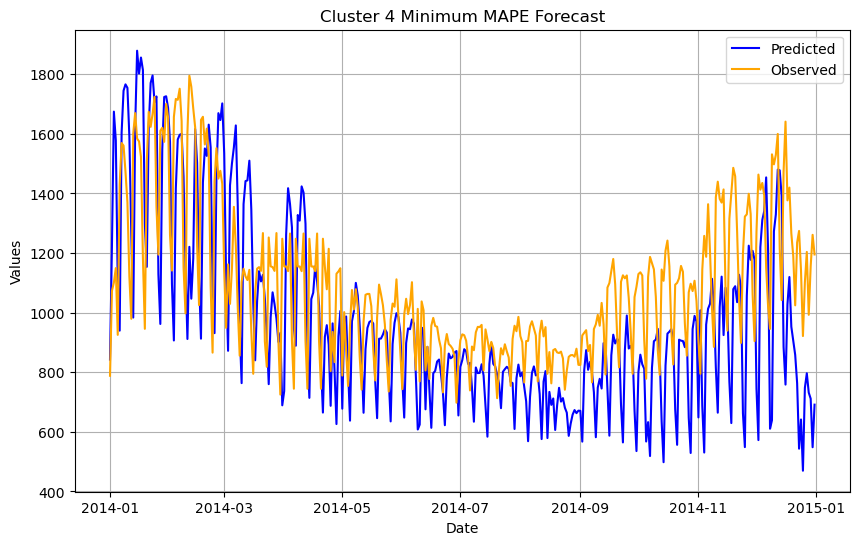

Maximum MAPE for Cluster 4: 94.97437483053875


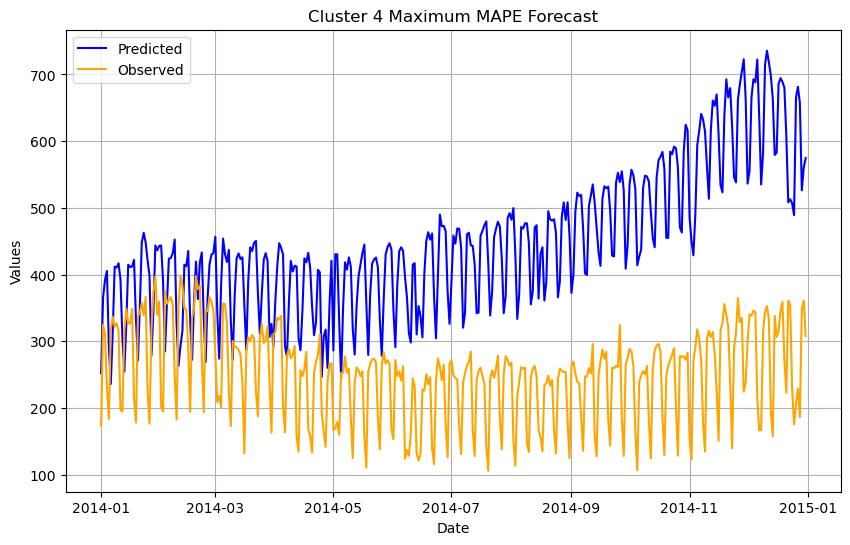

In [121]:
min_mapes = list()
max_mapes = list()

for i in range(len(clustered_customers)):
    min_mape = clustered_customers[i][0]
    max_mape = clustered_customers[i][0]
    for customer in clustered_customers[i]:
        if mape_values[customer] < mape_values[min_mape]:
            min_mape = customer
        if mape_values[customer] > mape_values[max_mape]:
            max_mape = customer

    min_mapes.append(min_mape)
    max_mapes.append(max_mape)

    print(f'Minimum MAPE for Cluster {i+1}: {mape_values[min_mape]}')

    plt.figure(figsize=(10, 6))

    plt.plot(predictions[min_mape]['ds'], predictions[min_mape]['yhat'], label='Predicted', color='blue')

    plt.plot(predictions[min_mape]['ds'], combined_df[customer_df.ds >= cutoff_date][min_mape], label='Observed', color='orange')

    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title(f'Cluster {i+1} Minimum MAPE Forecast')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'my_plot{i+1}.png')
    plt.show()
    



    print(f'Maximum MAPE for Cluster {i+1}: {mape_values[max_mape]}')

    plt.figure(figsize=(10, 6))

    plt.plot(predictions[max_mape]['ds'], predictions[max_mape]['yhat'], label='Predicted', color='blue')

    plt.plot(predictions[max_mape]['ds'], combined_df[customer_df.ds >= cutoff_date][max_mape], label='Observed', color='orange')

    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title(f'Cluster {i+1} Maximum MAPE Forecast')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'my_plot_max{i+1}.png')
    plt.show()

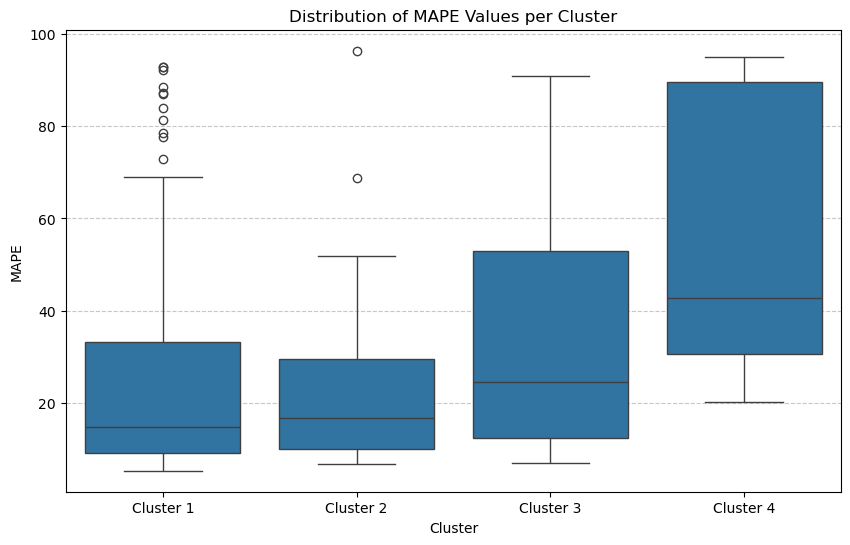

Average MAPE per cluster:
Cluster 1: 25.1147
Cluster 2: 25.9676
Cluster 3: 34.6636
Cluster 4: 55.6482


In [149]:
mape_data = []
clusters = []

for cluster, customers in enumerate(clustered_customers):
    for customer in customers:
        if customer in mape_values and mape_values[customer] <= 100:
            mape_data.append(mape_values[customer])
            clusters.append(f"Cluster {cluster+1}")

df = pd.DataFrame({
    'Cluster': clusters,
    'MAPE': mape_data
})

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='MAPE', data=df)
plt.title('Distribution of MAPE Values per Cluster')
plt.xlabel('Cluster')
plt.ylabel('MAPE')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

average_mapes = df.groupby('Cluster')['MAPE'].mean()

print("Average MAPE per cluster:")
for cluster, avg_mape in average_mapes.items():
    print(f"{cluster}: {avg_mape:.4f}")

In [109]:
time_period = []
time_mape_values = []

test_data_df = combined_df[customer_df.ds >= cutoff_date]

for customer, prediction in predictions.items():
    fourth = int(len(test_data_df[customer]) / 4)

    first_qtr_observed = np.array(test_data_df[customer][0:fourth], dtype=float)
    second_qtr_observed = np.array(test_data_df[customer][fourth:2*fourth], dtype=float)
    third_qtr_observed = np.array(test_data_df[customer][2*fourth:3*fourth], dtype=float)
    fourth_qtr_observed = np.array(test_data_df[customer][3*fourth:], dtype=float)

    first_qtr_predicted = np.array(prediction['yhat'][0:fourth], dtype=float)
    second_qtr_predicted = np.array(prediction['yhat'][fourth:2*fourth], dtype=float)
    third_qtr_predicted = np.array(prediction['yhat'][2*fourth:3*fourth], dtype=float)
    fourth_qtr_predicted = np.array(prediction['yhat'][3*fourth:], dtype=float)

    first_qtr_mape = calculate_mape(first_qtr_observed, first_qtr_predicted)
    second_qtr_mape = calculate_mape(second_qtr_observed, second_qtr_predicted)
    third_qtr_mape = calculate_mape(third_qtr_observed, third_qtr_predicted)
    fourth_qtr_mape = calculate_mape(fourth_qtr_observed, fourth_qtr_predicted)

    if first_qtr_mape <= 100:
        time_period.append("First Quarter of 2014")
        time_mape_values.append(first_qtr_mape)
    
    if second_qtr_mape <= 100:
        time_period.append("Second Quarter of 2014")
        time_mape_values.append(second_qtr_mape)
    
    if third_qtr_mape <= 100:
        time_period.append("Third Quarter of 2014")
        time_mape_values.append(third_qtr_mape)
    
    if fourth_qtr_mape <= 100:
        time_period.append("Fourth Quarter of 2014")
        time_mape_values.append(fourth_qtr_mape)

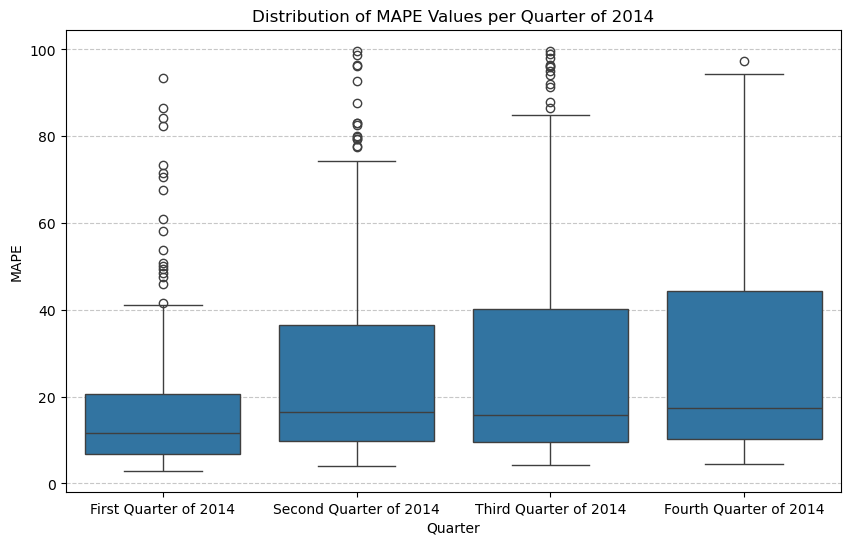

Average MAPE per Quarter:
First Quarter of 2014: 16.8634
Fourth Quarter of 2014: 28.7114
Second Quarter of 2014: 26.7000
Third Quarter of 2014: 27.9992


In [113]:
df = pd.DataFrame({
    'Quarter': time_period,
    'MAPE': time_mape_values
})

plt.figure(figsize=(10, 6))
sns.boxplot(x='Quarter', y='MAPE', data=df)
plt.title('Distribution of MAPE Values per Quarter of 2014')
plt.xlabel('Quarter')
plt.ylabel('MAPE')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Calculate and print average MAPE per Quarter
average_mapes = df.groupby('Quarter')['MAPE'].mean()

print("Average MAPE per Quarter:")
for quarter, avg_mape in average_mapes.items():
    print(f"{quarter}: {avg_mape:.4f}")
